# US Senators dataset

## Students

* Team: `18`
* Students: ` Quentin Bacuet, Ali Alami-Idrissi, Keshav Singh, Leandro Kieliger`
* Dataset: `US-Senators`

## Imports

In [1]:
# IPython magic to reload changes on external files
%load_ext autoreload
%autoreload 2

# Import general libs
import numpy as np
import pandas as pd
import scipy as sc
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pickle
# Import specific modules
from scipy import sparse
from pygsp import graphs, reduction
from scipy import linalg
from pyunlocbox import functions, solvers
from sklearn.cluster import KMeans
from IPython.display import display, HTML
from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual
from itertools import combinations
import ipywidgets as widgets
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
# Import utility functions from external files
from utils import *
from plot_utils import *
from graph_utils import *
from cluster_utils import *
from request_utils import *
from transducive_learning_utils import *




In [2]:
display(HTML("""
<style type="text/css">
div.output_png {
  display: flex;
  justify-content: center;
  margin-right:10%;
}
</style>
"""))

party_colormap = {'R':'red', 'D': 'dodgerblue', 'I':'limegreen'}

## Load processed data

In [3]:
votes = pd.read_pickle("data/processed/processed_votes.pickle")
print("\n\n\nThe vote dataframe is a " + str(votes.shape) + " table with senators as rows and vote positions as columns.")
display(votes.head(3))

# Bill descriptions
bill_descriptions = pd.read_csv("data/processed/processed_bill_descriptions.csv").set_index('bill_id')
display(bill_descriptions.head(3))

# Separate votes into "train" and "test" samples on a 80-20 basis
np.random.seed(2018)
votes_train, votes_test = split_dataframe(1, votes)

senators = pd.read_pickle("data/processed/processed_senators.pickle")
print("\n\n\nThe senators dataframe is a " + str(senators.shape) + " table with senators as rows and ID, party and names as columns.")
display(senators.head(3))

senators_party = senators['party']
numerical_labels = np.vectorize({'R':0.,'D':0.12,'I':0.223}.get)(senators_party)




The vote dataframe is a (105, 23) table with senators as rows and vote positions as columns.


id,hconres71-115-245-1,hjres38-115-43-1,hr1-115-303-1,hr1865-115-60-2,hr2-115-143-2,hr2430-115-187-1,hr2810-115-199-1,hr3364-115-175-1,hr5515-115-128-2,hr5895-115-139-2,...,hr72-115-28-1,s2155-115-54-2,s2554-115-209-2,s722-115-147-1,s84-115-27-1,s89-115-102-1,sconres3-115-26-1,sres176-115-138-1,sres584-115-162-2,treatydoc.114-12-115-98-1
member_id,,,,,,,,,,,,,,,,,,,,,
A000360,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
B000575,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
B000944,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0


,summary,summary_short
bill_id,,
hr695-115,NaN,NaN
pn2209-115,NaN,NaN
s756-115,Save Our Seas Act of 2017 or the SOS Act of 20...,Save Our Seas Act of 2017 or the SOS Act of 20...





The senators dataframe is a (105, 5) table with senators as rows and ID, party and names as columns.


,party,first_name,last_name,votes_with_party_pct,name
member_id,,,,,
A000360,R,Lamar,Alexander,96.15,Lamar Alexander
B000575,R,Roy,Blunt,98.29,Roy Blunt
B000944,D,Sherrod,Brown,93.80,Sherrod Brown


## Load labels

## Building the similarity graph

Clustering coefficient: 0.6337152265723697
Diameter: 8


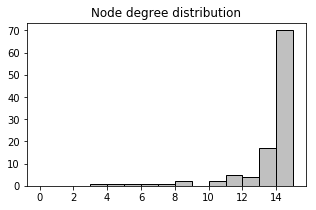

In [4]:
features = [votes_train.values]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_max_neighbors(sparsify_with_limit(arg, .5), 15)]

# Builds the adjacency matrix by computing the similarities between senators.
# This implementation can be used to feed various features matrices and apply a different distance function and
# sparsification function to each of them. A weighted average is then returned. Here, we only use the vote features.
adjacency = get_adjacency_multidistance(features, weights, cosine_similarity, lambda x:x, sparsification_functions)


G = graphs.Graph(adjacency)
#G = reduction.graph_sparsify(G, 0.75)
G.compute_differential_operator()
G.compute_fourier_basis()
G.compute_laplacian()

print("Clustering coefficient: " + str(nx.average_clustering(nx.from_numpy_matrix(adjacency))))
print("Diameter: " + str(nx.diameter(nx.from_numpy_matrix(adjacency))))
plt.figure(figsize=(5,3))
plt.hist(adjacency.sum(1), bins=np.linspace(0,15,16), color='silver', lw=1, edgecolor='black')
plt.title("Node degree distribution")
plt.savefig("deg_distribution.png")
plt.show()

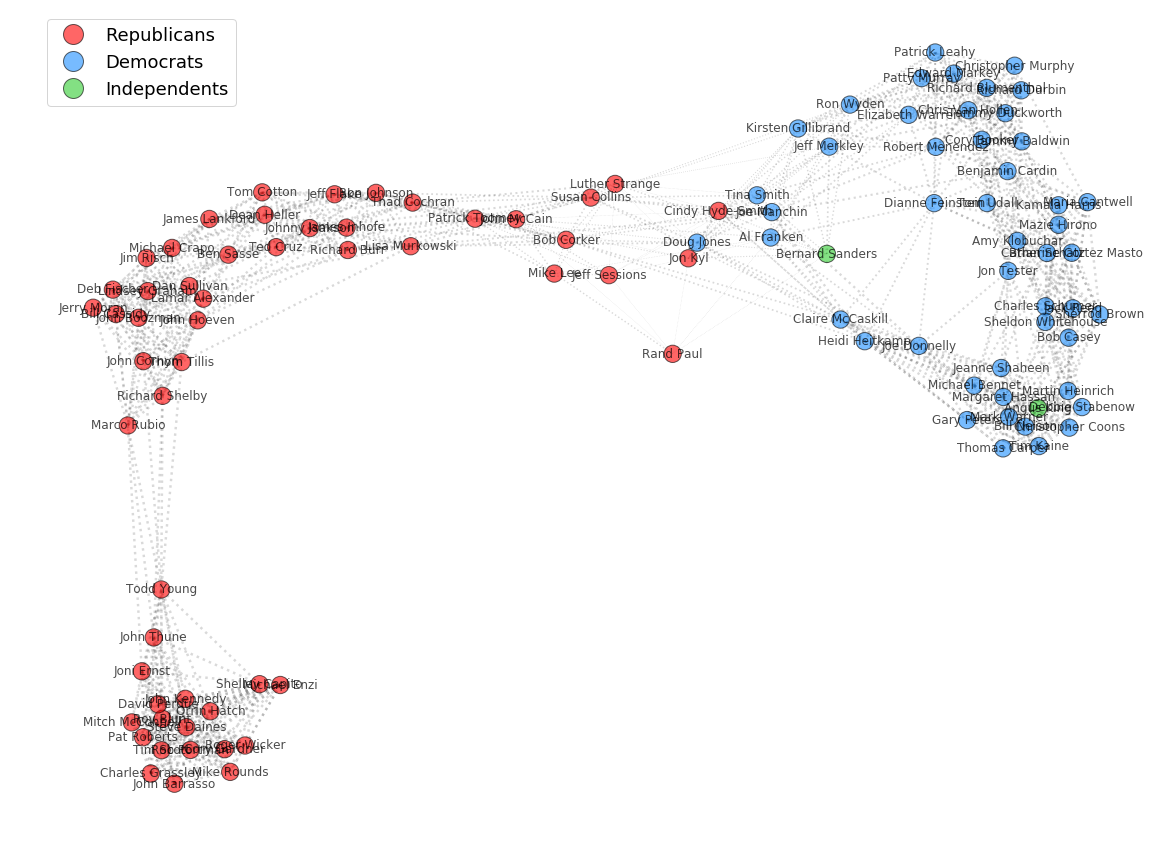

In [5]:
plot_signal(G.W.todense(), senators['party'].map(party_colormap), labels=senators['name'], scale=[0,1])
r = mlines.Line2D([], [], color='red', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black', alpha=0.6, markersize=20, label="Republicans")
d = mlines.Line2D([], [], color='dodgerblue', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black',  alpha=0.6,markersize=20, label="Democrats")
i = mlines.Line2D([], [], color='limegreen', marker='o', linestyle='', markeredgewidth=1, markeredgecolor='black', alpha=0.6, markersize=20, label="Independents")

plt.legend(handles=[r,d,i], prop={'size':18})
plt.savefig("similarity_graph.png")

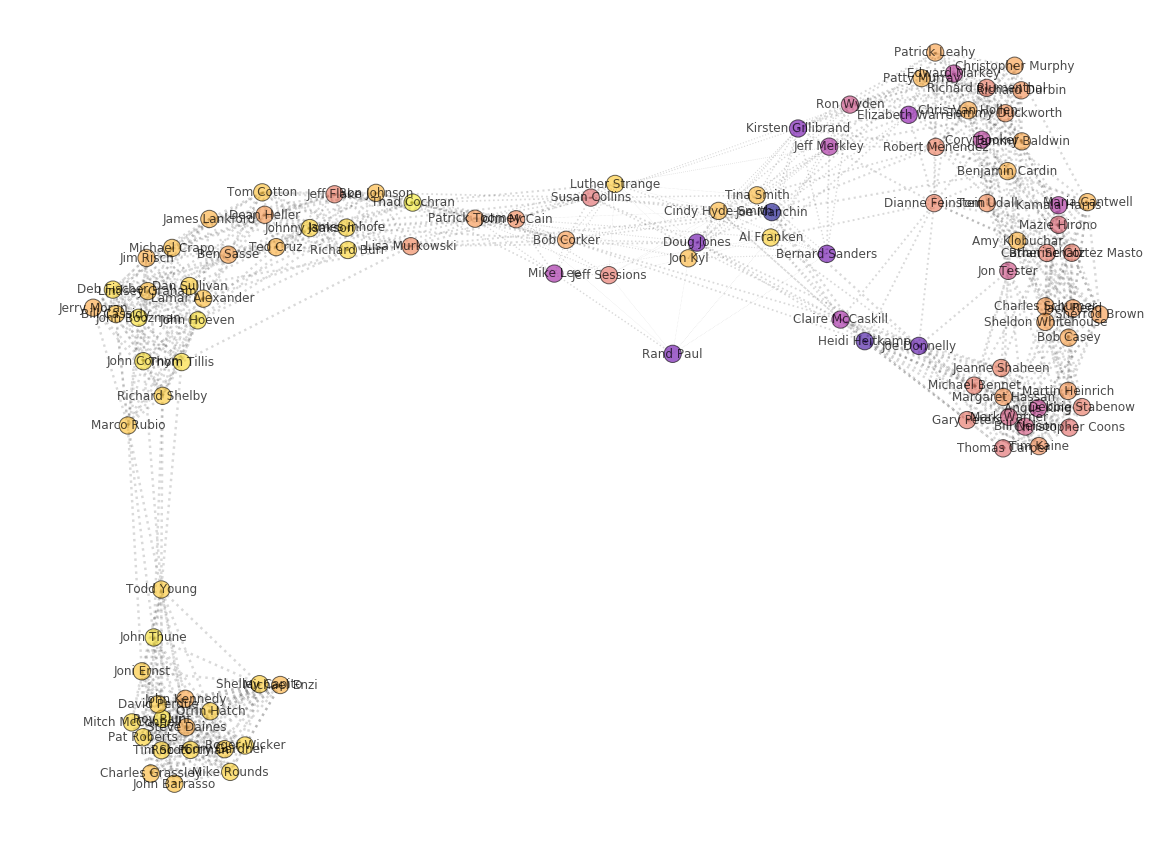

In [6]:
plot_signal(G.W.todense(), senators['votes_with_party_pct'].map(float), labels=senators['name'], scale=[75,100], colormap='plasma')

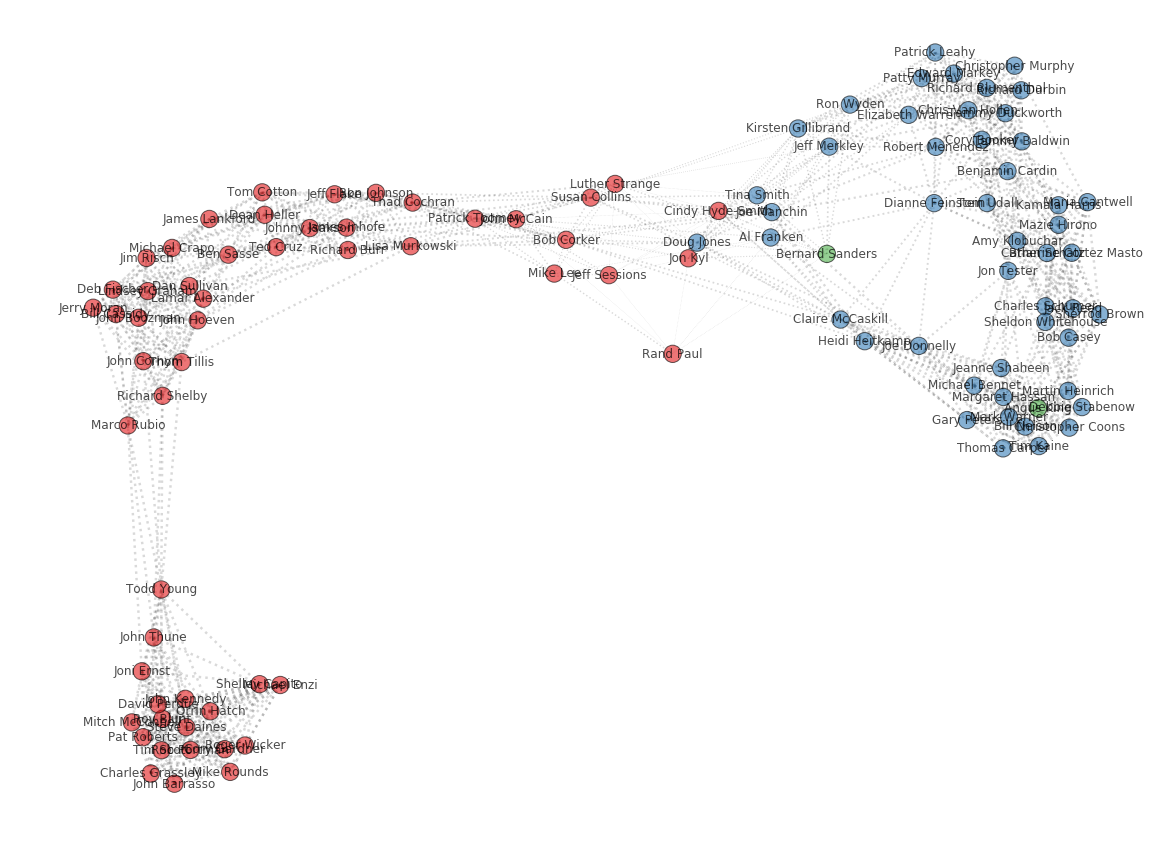

In [7]:
plot_signal(G.W.todense(), numerical_labels, labels=senators['name'], scale=[0,1])

## Clustering the bills

Building a similarity graph where node correspond to bills and features to senators, we can identify which bills are similar in terms of voting base. Therefore, each cluster should then correspond to a different electoral support.

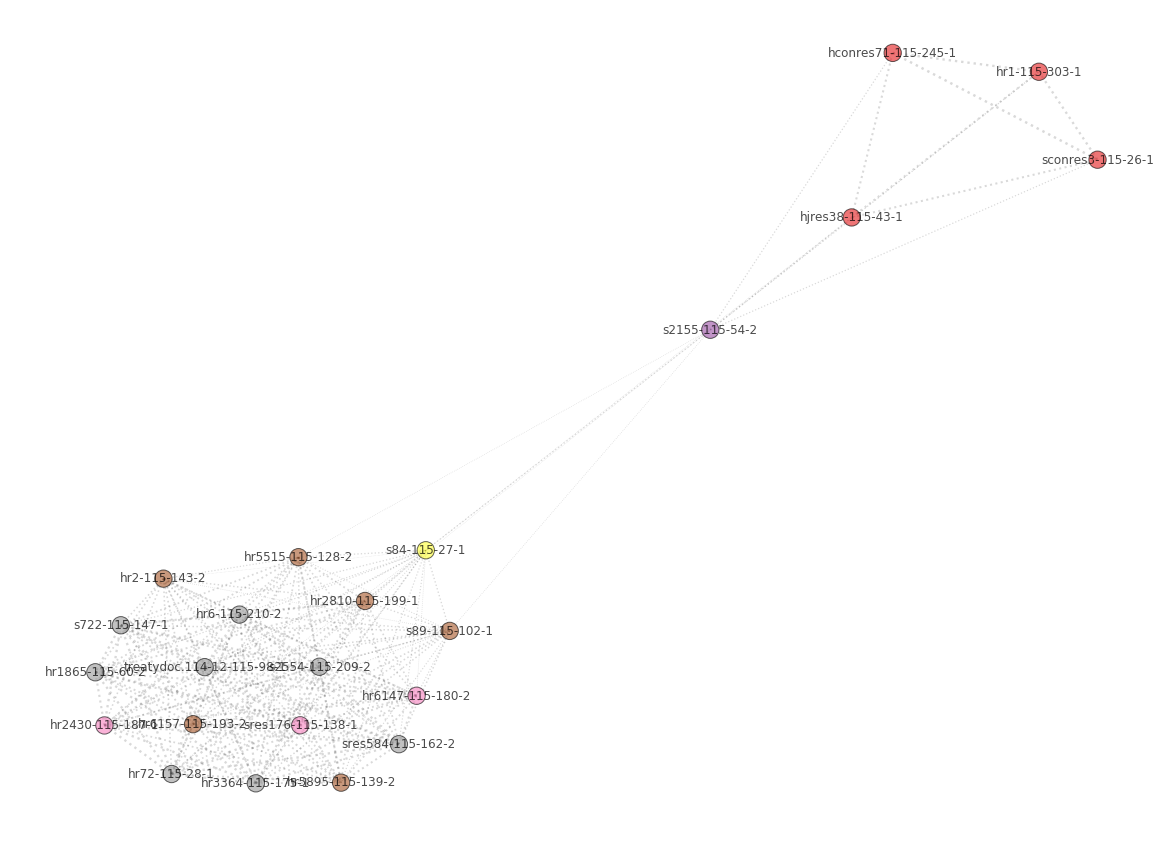

In [8]:
bill_cluster_count = 3

features_bills = [votes_train.T.values]
weights = [1]
sparsification_functions = [lambda arg : sparsify_with_limit(sparsify_with_max_neighbors(arg,75),0.7)]
adjacency_bills = get_adjacency_multidistance(features_bills, weights, cosine_similarity, lambda x:x, sparsification_functions)

node_degrees = adjacency_bills.sum(1)
G_nx = nx.from_numpy_matrix(adjacency_bills)

largest_component = max(nx.connected_components(G_nx), key=len)
s = G_nx.subgraph(largest_component)

G_bills = graphs.Graph(nx.to_numpy_matrix(s))
#G_bills = reduction.graph_sparsify(G_bills,0.33)

plot_signal(G_bills.W.todense(), votes_train.sum(0) / votes_train.shape[0], scale=[0,1],labels = votes_train.columns  )

(array([ 4.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1., 17.]),
 array([ 3.70270651,  4.91743102,  6.13215553,  7.34688004,  8.56160455,
         9.77632906, 10.99105357, 12.20577807, 13.42050258, 14.63522709,
        15.8499516 ]),
 <a list of 10 Patch objects>)

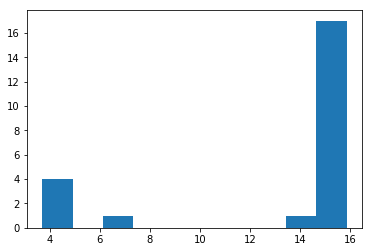

In [9]:
plt.hist(node_degrees)

In [55]:
unique_bills = {}
all_bills = {}
best_bills_per_method = []
def print_selected_votes(votes_list,best_bills_idxs):
    selected_votes_unique_ids = votes_list.iloc[:, best_bills_idxs].columns.values
    for v in selected_votes_unique_ids:
        print_info(v)
    bills = [x.split('-')[0] for x in selected_votes_unique_ids]
    return set(bills)

def add_to(dict_,keys):
    for key in keys:
        if key in dict_:
            dict_[key] += 1
        else:
            dict_[key] = 1
        

### Method 1: Get biggest Variance

In [56]:
var = np.zeros(votes_train.shape[1])

for i in range(votes_train.shape[1]):
    a = votes_train.values[:,i]
    var[i] = np.var(a[a != 0])
    
best_bills = var.argsort()[-bill_cluster_count:]
best_bills

array([13, 21,  9])

In [57]:
add_to(all_bills,best_bills)
add_to(unique_bills,print_selected_votes(votes_train,best_bills))
best_bills_per_method.append(best_bills.astype(int))

[13 21  9]
============== INFORMATION REGARDING sconres3-115-26-1 ============== 

Roll call: 26
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00026

RELATED BILL INFORMATION

Bill title: A concurrent resolution setting forth the congressional budget for the United States Government for fiscal year 2017 and setting forth the appropriate budgetary levels for fiscal years 2018 through 2026.

Bill url:  https://www.govtrack.us/congress/bills/115/sconres3

Short description: (This measure has not been amended since it was passed by the Senate on January 12, 2017. The summary of that version is repeated here.) Highlights:  This concurrent resolution establishes the FY2017 congressional budget resolution, which provides a framework for congressional consideration of revenue, spending, and other budget-related legislation. The budget resolution is a nonbinding framework used by Congress and cannot be signed into law or ve

### Method 2: Get smallest number of neighbors

In [58]:
temp = adjacency_bills.copy()
temp[temp > 0] = 1
best_bills = temp.sum(0).argsort()[:bill_cluster_count]
best_bills

array([13,  9, 21])

In [59]:
add_to(all_bills,best_bills)
add_to(unique_bills,print_selected_votes(votes_train,best_bills))
best_bills_per_method.append(best_bills.astype(int))

[13  9 21]
============== INFORMATION REGARDING sconres3-115-26-1 ============== 

Roll call: 26
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00026

RELATED BILL INFORMATION

Bill title: A concurrent resolution setting forth the congressional budget for the United States Government for fiscal year 2017 and setting forth the appropriate budgetary levels for fiscal years 2018 through 2026.

Bill url:  https://www.govtrack.us/congress/bills/115/sconres3

Short description: (This measure has not been amended since it was passed by the Senate on January 12, 2017. The summary of that version is repeated here.) Highlights:  This concurrent resolution establishes the FY2017 congressional budget resolution, which provides a framework for congressional consideration of revenue, spending, and other budget-related legislation. The budget resolution is a nonbinding framework used by Congress and cannot be signed into law or ve

### Method 3: Get closest points of the centers of the cluster of the Bills

In [60]:
G_bills.compute_laplacian()
G_bills.compute_fourier_basis()
embedding_dimension = 2
embedding = G_bills.U[:,1:1+embedding_dimension]
clusters, centers = gen_kmeans(embedding, bill_cluster_count)
vote_repr = np.zeros(bill_cluster_count)

for j in range(bill_cluster_count):
    dist = np.linalg.norm(embedding - centers[j],axis=1)
    vote_repr[j] = np.argmin(dist)
            
vote_repr

array([ 9.,  1., 21.])

In [61]:
add_to(all_bills,vote_repr)

add_to(unique_bills,print_selected_votes(votes_train,vote_repr))
best_bills_per_method.append(vote_repr.astype(int))

[ 9.  1. 21.]
============== INFORMATION REGARDING hconres71-115-245-1 ============== 

Roll call: 245
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00245

RELATED BILL INFORMATION

Bill title: Establishing the congressional budget for the United States Government for fiscal year 2018 and setting forth the appropriate budgetary levels for fiscal years 2019 through 2027.

Bill url:  https://www.govtrack.us/congress/bills/115/hconres71

Short description: (This measure has not been amended since it was passed by the Senate on October 19, 2017. The summary of that version is repeated here.) Highlights:  This concurrent resolution establishes the FY2018 congressional budget resolution, which provides a framework for congressional consideration of legislation addressing revenues, spending, and other budget-related issues. The budget resolution is a nonbinding framework used by Congress and cannot be signed into law or v

### Method 4: Get the bills with biggest intracluster std

In [62]:
var = np.zeros(votes_train.shape[1])
rep_indexes = np.nonzero(numerical_labels == 0)[0]
dem_indexes = np.nonzero(numerical_labels == 0.12)[0] 
rep_data = votes_train.iloc[rep_indexes]
dem_data = votes_train.iloc[dem_indexes]
rep_std = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,rep_data.values)
dem_data = np.apply_along_axis(lambda x : np.std(x[x!=0]),0,dem_data.values)
stds = (rep_std+dem_data)/2

best_bills = stds.argsort()[-bill_cluster_count:]
best_bills

array([22,  4, 16])

In [63]:
add_to(all_bills,best_bills)

add_to(unique_bills,print_selected_votes(votes_train,best_bills))
best_bills_per_method.append(best_bills.astype(int))

[22  4 16]
============== INFORMATION REGARDING hr2810-115-199-1 ============== 

Roll call: 199
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00199

RELATED BILL INFORMATION

Bill title: To authorize appropriations for fiscal year 2018 for military activities of the Department of Defense and for military construction, to prescribe military personnel strengths for such fiscal year, and for other purposes.

Bill url:  https://www.govtrack.us/congress/bills/115/hr2810

Short description: National Defense Authorization Act for Fiscal Year 2018 This bill authorizes FY2018 appropriations and sets forth policies for Department of Defense (DOD) programs and activities, including military personnel strengths. It does not provide budget authority, which is provided in subsequent appropriations legislation.  The bill authorizes appropriations to DOD for: (1) Procurement, including aircraft, missiles, weapons and tracked comb

### Method 5: Get most central nodes using PageRank 

In [64]:
nx_graph = nx.from_numpy_matrix(G_bills.W.todense())
pagerank = nx.pagerank(nx_graph)
pagerank = np.array(list(pagerank.values()))
best_bills = np.argsort(-pagerank)[:bill_cluster_count]
best_bills

array([ 5, 22,  4])

In [65]:
add_to(all_bills,best_bills)
add_to(unique_bills,print_selected_votes(votes_train,best_bills))
best_bills_per_method.append(best_bills.astype(int))

[ 5 22  4]
============== INFORMATION REGARDING s84-115-27-1 ============== 

Roll call: 27
Session: 1

https://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=115&session=1&vote=00027

RELATED BILL INFORMATION

Bill title: A bill to provide for an exception to a limitation against appointment of persons as Secretary of Defense within seven years of relief from active duty as a regular commissioned officer of the Armed Forces.

Bill url:  https://www.govtrack.us/congress/bills/115/s84

Short description: (This measure has not been amended since it was introduced. The expanded summary of the Senate passed version is repeated here.) (Sec. 1) This bill allows the first person, and only such person, appointed as Secretary of Defense after the enactment of this bill to be a person who is, on the date of appointment, not within at least three years after relief from active duty as a commissioned officer of a regular component of the Armed Forces. (Under current

In [66]:
print('Unique votes number in training set: {}'.format(len(set(map(lambda x: x.split('-')[0],votes_train.columns)))))

Unique votes number in training set: 23


In [22]:
# Print how many times every bill was selected and every vote was selected
unique_bills,all_bills,best_bills_per_method

({'sconres3': 3,
  'hr1': 3,
  'hconres71': 3,
  'hr2810': 2,
  's89': 1,
  'hr5515': 2,
  's84': 1},
 {13: 2, 21: 3, 9: 3, 1.0: 1, 22: 2, 4: 2, 16: 1, 5: 1},
 [array([13, 21,  9]),
  array([13,  9, 21]),
  array([ 9,  1, 21]),
  array([22,  4, 16]),
  array([ 5, 22,  4])])

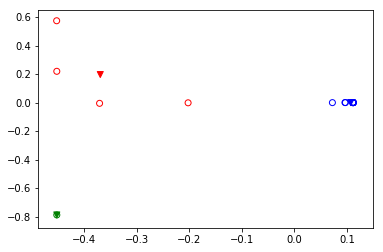

In [23]:
n = len(embedding)
colors = {0:'red',1:'blue',2:'green', 3:'orange'}

for i in range(n-1):
    plt.scatter(embedding[i,0], embedding[i,1], facecolors='none', edgecolors=colors[clusters[i]])
    
plt.scatter(centers[:,0], centers[:,1], marker='v', color=list(colors.values()))

### Find the best initial 3 votes combination

In [34]:
def predict_using_initial_votes(votes_selection,votes_df,G_votation,number_of_trials = 1):
    # Using transductive learning
    w = np.zeros(votes_df.shape[1])
    w[votes_selection] = 1
    accuracies_accumulator = 0
    for senator in range(votes_df.shape[0]):
        votes_np = votes_df.iloc[senator,:].values
        available_votes_idx = np.nonzero(votes_np != 0)[0]
        ground_truth = get_thresholded_values(votes_np,0)
        sol, sol_bin = reconstruct_signal(G_votation, w, ground_truth,number_of_trials=number_of_trials)
        accuracies_accumulator += accuracy(ground_truth[available_votes_idx],sol_bin[available_votes_idx])
    accuracies_accumulator /= votes_df.shape[0]
    return accuracies_accumulator


def knn_predict(similar_senators_votes):
    prediction = np.apply_along_axis(lambda a: np.histogram(a,  bins=[-1,0,1,2])[0], 0, similar_senators_votes)
#     print(prediction)
    prediction = np.argmax(prediction[[0,2],:],axis=0)
    prediction[prediction == 0] = -1
    return prediction
def predict_using_initial_votes_2(votes_selection,votes_df,number_of_neighbors = 3):
    # Using KNN
    accuracies_accumulator = 0
    tmp = votes_df.iloc[:,votes_selection].values
    model = NearestNeighbors(n_neighbors=number_of_neighbors+1, algorithm='ball_tree').fit(tmp)
    distances, indices = model.kneighbors(tmp)
    distances = distances[:,1:]
    indices = indices[:,1:]
    selector = np.arange(votes_df.shape[1])
    selector = np.nonzero(~np.isin(selector,votes_selection))[0]
    total = 0
    for senator in range(votes_df.shape[0]):
        similar_senators = indices[senator]
        similar_senators_votes = votes_df.iloc[similar_senators].values[:,selector]
        ground_truth = votes_df.iloc[senator,selector].values
        available_votes_idx = np.nonzero(ground_truth != 0)[0]
        sol = knn_predict(similar_senators_votes)
        ground_truth = ground_truth[available_votes_idx]
        if  len(ground_truth):
            acc = accuracy(ground_truth,sol[available_votes_idx])
            accuracies_accumulator  += acc
            total+=1
    accuracies_accumulator /= total
    return accuracies_accumulator


def find_best_votes(selected_search_space,votes_df,G_bills):
    all_votes_combinations_accuracies = []
    all_votes_combinations_accuracies_2 = []
    for idx,votes_combination in enumerate(selected_search_space):
        print(str(idx+1)+'/'+str(len(selected_search_space)),end='\r')
        all_votes_combinations_accuracies.append(predict_using_initial_votes(votes_combination,votes_train,G_bills))
        all_votes_combinations_accuracies_2.append(predict_using_initial_votes_2(votes_combination,votes_train))

        
    best_method_1,best_method_2 = np.argmax(np.array(all_votes_combinations_accuracies)),np.argmax(np.array(all_votes_combinations_accuracies_2))
    combination_1,combination_2 = selected_search_space[best_method_1],selected_search_space[best_method_2]
    
    data = (best_method_1,best_method_2),(all_votes_combinations_accuracies[best_method_1],all_votes_combinations_accuracies_2[best_method_2])
    log_best_votes(data,selected_search_space,votes_df)



all_votes_combinations = [[int(y) for y in x] for x in combinations(all_bills.keys(),3)]
G_bills.compute_differential_operator()

def log_best_votes(data,search_space,votes_df):
    (m1,m2),(acc1,acc2) = data
    print('---------Transductive Learning benchmark------------')
    print('Best Value Index: {}'.format(m1))
    print('Accuracy: {}'.format(acc1))
    print('Votes idxs: {}'.format(search_space[m1]))
    print('Votes selected {}'.format([x for x in votes_df.iloc[:,search_space[m1]].columns]))
    
    print('---------KNN benchmark------------')
    print('Best Value Index: {}'.format(m2))
    print('Accuracy: {}'.format(acc2))
    print('Votes idxs: {}'.format(search_space[m2]))
    print('Votes selected {}'.format([x for x in votes_df.iloc[:,search_space[m2]].columns]))

In [37]:
find_best_votes(all_votes_combinations,votes_train,G_bills)

---------Transductive Learning benchmark------------
Best Value Index: 6
Accuracy: 0.9494263845195524
Votes idxs: [13, 9, 1]
Votes selected ['sconres3-115-26-1', 'hconres71-115-245-1', 's722-115-147-1']
---------KNN benchmark------------
Best Value Index: 41
Accuracy: 0.9573140367258017
Votes idxs: [9, 22, 16]
Votes selected ['hconres71-115-245-1', 'hr2810-115-199-1', 's89-115-102-1']


In [35]:
find_best_votes(best_bills_per_method,votes_train,G_bills)

---------Transductive Learning benchmark------------
Best Value Index: 2
Accuracy: 0.9481823559463313
Votes idxs: [ 9  1 21]
Votes selected ['hconres71-115-245-1', 's722-115-147-1', 'hr1-115-303-1']
---------KNN benchmark------------
Best Value Index: 2
Accuracy: 0.9407615443838355
Votes idxs: [ 9  1 21]
Votes selected ['hconres71-115-245-1', 's722-115-147-1', 'hr1-115-303-1']


## Vote selection

['hconres71-115-245-1' 's722-115-147-1' 'hr1-115-303-1']


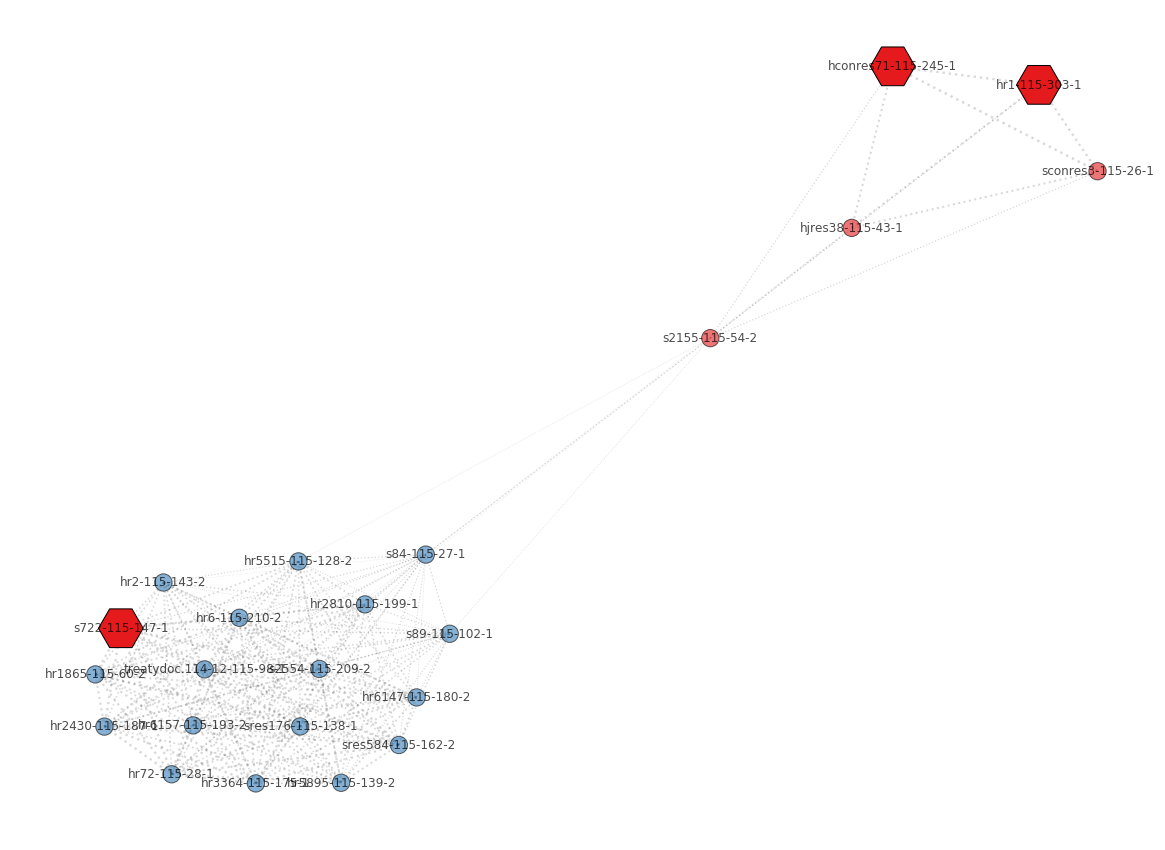

In [28]:
vote_selection = vote_repr.astype(int)
print(votes_train.iloc[:, vote_selection].columns.values)
plot_signal(G_bills.W.todense(), 
            clusters, 
            labels=votes_train.T.index, 
            scale=[0,9], 
            highlight_node=vote_selection,
            colormap=plt.get_cmap('Set1'))

## Embedding you in the graph

In [67]:
your_votes = [1,1,-1]
other_senators_vote = votes_train.values[:,vote_selection]

In [68]:
def compute_similarity(senator_votes,your_votes):
    return euclidean_distance(senator_votes, your_votes)

against='Against'
pro='Pro'
neutral='Neutral'

G_extended = None

@interact(vote1=[(against,-1.0),(neutral,0.0),(pro,1.0)],vote2=[(against,-1.0),(neutral,0.0),(pro,1.0)],vote3=[(against,-1.0),(neutral,0.0),(pro,1.0)])
def choose(vote1=1.0,vote2=1.0,vote3=1.0):
    your_votes=[vote1,vote2,vote3]
    other_senators_vote = votes_train.values[:,vote_selection]
    similarity_vector = np.apply_along_axis(compute_similarity, 1, other_senators_vote,your_votes)
    similarity_vector = sparsify_with_limit(gaussian_kernel(similarity_vector),0.5)

    top_similar = similarity_vector.argsort()[-3:][::-1]
    similar_senators = senators.iloc[top_similar]
    show_portraits(similar_senators)
    new_columns = np.append(similarity_vector, 0)

    n = len(adjacency)
    new_adjacency = np.zeros((n+1, n+1))
    new_adjacency[:n,:n] = adjacency
    new_adjacency[n,:] = new_columns
    new_adjacency[:,n] = new_columns

    global G_extended
    G_extended = graphs.Graph(new_adjacency)
    G_extended.set_coordinates('spring', seed=2018)
    G_extended.compute_fourier_basis()
    G_extended.compute_laplacian()
    G_extended.compute_differential_operator()
    
    new_labels = np.append(senators['name'].values, ['you'])
    
    plot_signal(new_adjacency, np.append(numerical_labels, [0]), labels=new_labels, scale=[0,1], highlight_node=[105])
    show_2D_embedding(G_extended.U[:,1:3], senators_party)
    show_political_spectrum(G_extended.U[:,1:3], n, colors, senators_party)

interactive(children=(Dropdown(description='vote1', index=2, options=(('Against', -1.0), ('Neutral', 0.0), ('P…

# Predicting votes based on votes from similar senators (SHOULD BE RECOMPILED WITH OLD GRAPH)

In [ ]:
# Binarize labels
labels_bin = get_thresholded_values(votes_test.values[:,35], threshold=0)
n = len(labels_bin)

mn_ratio = 0.3 # Ratio of node labels to keep
m = int(mn_ratio * n)  # Number of measurements.
w = get_mask(n,m)

plot_signal(G.W.todense(), labels_bin, labels=senators['name'], scale=[-1.25,1.25], colormap=plt.get_cmap('RdYlGn'))

In [ ]:
sol, sol_bin =  reconstruct_signal(G,w,labels_bin)
plot_prediction(G, sol_bin, labels_bin, w)
plt.savefig("prediction_result.png")
print("Error binarized: " + str(error(labels_bin, sol_bin)))
print("Accuracy binarized: " + str(accuracy(labels_bin, sol_bin)))
print("Error non binarized: " + str(error(labels_bin, sol)))

# What about you ?


In [50]:
def predict_your_votes(G, positions, p=2, number_of_trials = 50):
    bill_votes = np.append(positions, 0)
    w = np.append(np.ones(len(positions)), 0)    

    return reconstruct_signal(G, w, get_thresholded_values(bill_votes,0),number_of_trials=number_of_trials)

sol, sol_binarized = predict_your_votes(G_extended, votes_train.iloc[:,2])
print("On vote x you would have voted " + str(sol_binarized[-1]) + " ("+str(sol[-1])+")")

On vote x you would have voted 1.0 (0.9727594798700638)


# Going further, can we predict the voting outcome based on votes of swing senators ?

Swing senators are those that link the democratic and republican clusters

In [51]:
## Identifying swing votes
def swing_scores(adjacency,labels):
    similarity_mask = (np.repeat(labels[np.newaxis,:],adjacency.shape[0],axis=0) != labels [:,np.newaxis])
    weights_sum = adjacency.sum(1)
    swing_score = (similarity_mask*adjacency).sum(1)
    swing_score /= weights_sum
    return swing_score  
    
parties = senators_party.copy()
parties[parties == 'I'] = 'D'
swing_senators = np.nonzero(swing_scores(np.asarray(G.W.todense()),parties) > 0.1)[0]
non_swing_senators = np.nonzero(swing_scores(G.W.todense(),parties) <= 0.1)[0]

print(senators['name'].iloc[swing_senators])

predict_and_compare(G, votes_test, swing_senators)

member_id
C001035         Susan Collins
C001071            Bob Corker
F000457            Al Franken
G000555    Kirsten Gillibrand
H001069        Heidi Heitkamp
H001079      Cindy Hyde-Smith
J000300            Doug Jones
K000352               Jon Kyl
M001153        Lisa Murkowski
M001170      Claire McCaskill
M001176          Jeff Merkley
M001183           Joe Manchin
P000603             Rand Paul
S000033       Bernard Sanders
S001141         Jeff Sessions
S001202        Luther Strange
S001203            Tina Smith
W000779             Ron Wyden
Name: name, dtype: object
Outcome accuracy: nan


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


([], [])

~85% accuracy. How does that compare to the same number of senators but picked at random ? 

In [ ]:
np.random.seed(2018)
random_senators = np.random.choice(len(senators), len(swing_senators), replace=False)
print(senators[['name', 'party']].iloc[random_senators])
predict_and_compare(G, votes_test, random_senators)

In [ ]:
labels_bin = get_thresholded_values(votes_test.values[:,8], threshold=0)

mask = np.zeros(votes_test.shape[0])
mask[swing_senators] = 1

sol, sol_bin =  reconstruct_signal(G,mask,labels_bin)
plot_prediction(G, sol_bin, labels_bin, mask)

print("Error binarized: " + str(error(labels_bin, sol_bin)))
print("Accuracy binarized: " + str(accuracy(labels_bin, sol_bin)))
print("Error non binarized: " + str(error(labels_bin, sol)))
